![jakob-owens-CiUR8zISX60-unsplash.jpg](images/jakob-owens-CiUR8zISX60-unsplash.jpg)

<H1 align='center'>Analysis and Recommendations for Film Content Development </H1>

Data analysis and visualizations by Taylor Hale Robert, Naomi Weinberger and Harrison Gu for the purpose of cretaing recommendations for the development of an Original Film content series for Microsoft Studios.

*Import the appropriate packages.*

In [98]:
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import tmdbsimple as tmdb
from datetime import datetime
import sqlite3
import seaborn as sns
from config import tmdb_key
tmdb.API_KEY = tmdb_key
%matplotlib inline

<H2>Relationship between Production Budget and ROI</H2>

In [99]:
#import dataset and create main dataframe
df = pd.read_csv("zippedData/{}".format('tn.movie_budgets.csv.gz'))

In [100]:
#formatting columns into workable/relevant types
df['release_date'] = pd.to_datetime(df['release_date'], format='%b %d, %Y')
df['production_budget'] = df['production_budget'].replace('[\$,]', '', regex=True).astype(float)
df['domestic_gross'] = df['domestic_gross'].replace('[\$,]', '', regex=True).astype(float)
df['worldwide_gross'] = df['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)

In [101]:
#filter out old movies
df_recent = df[df['release_date'] >= datetime(2000, 1, 1)]

In [102]:
#analyze budget stats
df_recent['production_budget'].agg(['mean','median','std'])

mean      3.450823e+07
median    1.800000e+07
std       4.550905e+07
Name: production_budget, dtype: float64

In [103]:
#lower limit of production budget (flexible)
df_recent = df_recent[df_recent['production_budget'] >= 1000000]

In [104]:
#create 'roi' column
df_recent['roi'] = ((df_recent['worldwide_gross'] - df_recent['production_budget'])/df_recent['production_budget'])*100

In [105]:
df_recent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4032 entries, 0 to 5325
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 4032 non-null   int64         
 1   release_date       4032 non-null   datetime64[ns]
 2   movie              4032 non-null   object        
 3   production_budget  4032 non-null   float64       
 4   domestic_gross     4032 non-null   float64       
 5   worldwide_gross    4032 non-null   float64       
 6   roi                4032 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 252.0+ KB


In [106]:
#remove films with $0 gross sales (outlier or input error)
df_recent = df_recent[df_recent['roi'] != -100]

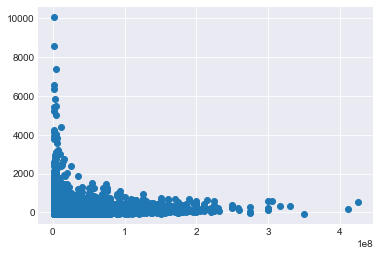

In [107]:
fig, ax = plt.subplots()
ax.scatter(df_recent['production_budget'], df_recent['roi']);

In [108]:
#high budget films
df_high = df_recent[df_recent['production_budget'] >= 100000000]

In [109]:
#medium budget films
df_med = df_recent[(df_recent['production_budget'] >= 50000000) & (df_recent['production_budget'] < 100000000)]

In [110]:
#low budget films
df_low = df_recent[(df_recent['production_budget'] >= 1000000) & (df_recent['production_budget'] < 50000000)]

*Proceed to explore relationship between ROI and budget*

In [111]:
df_recent['roi'].agg(['mean','median','std'])

mean      208.341748
median     80.819225
std       526.485946
Name: roi, dtype: float64

In [112]:
df_high['roi'].agg(['mean','median','std', 'min', 'max'])

mean      209.215227
median    175.320107
std       179.764220
min       -97.181818
max       973.354526
Name: roi, dtype: float64

In [113]:
df_med['roi'].agg(['mean','median','std', 'min', 'max'])

mean       160.439684
median      98.658093
std        238.823472
min        -99.205725
max       1527.246076
Name: roi, dtype: float64

In [114]:
df_low['roi'].agg(['mean','median','std', 'min', 'max'])

mean        218.684514
median       54.948808
std         598.351240
min         -99.997400
max       10075.949000
Name: roi, dtype: float64

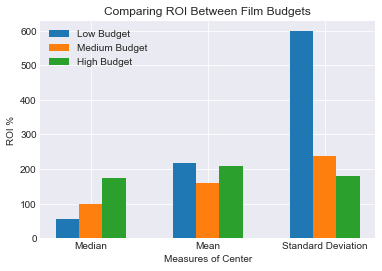

In [115]:
# create data
x = np.arange(3)
y1 = list(df_low['roi'].agg(['median','mean','std']))
y2 = list(df_med['roi'].agg(['median','mean','std']))
y3 = list(df_high['roi'].agg(['median','mean','std']))
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width)
plt.bar(x, y2, width)
plt.bar(x+0.2, y3, width)
plt.title('Comparing ROI Between Film Budgets')
plt.xticks(x, ['Median', 'Mean', 'Standard Deviation'])
plt.xlabel("Measures of Center")
plt.ylabel("ROI %")
plt.legend(["Low Budget", "Medium Budget", "High Budget"])
plt.style.use('seaborn-darkgrid')
plt.show()

<H2>Relationship between MPAA rating and ROI</H2>

In [116]:
#import dataset
zippedData = ['tmdb.movies.csv.gz']
#make dataframe
tmdb_movies = pd.read_csv("zippedData/{}".format(zippedData[0]))
tmdb_movies.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [117]:
#formatting
tmdb_movies['release_date'] = pd.to_datetime(tmdb_movies['release_date'], format='%Y-%m-%d')
#sort out movies produced prior to 2000
movies_recent = tmdb_movies[tmdb_movies['release_date'] >= datetime(2000, 1, 1)]
movies_recent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26398 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         26398 non-null  int64         
 1   genre_ids          26398 non-null  object        
 2   id                 26398 non-null  int64         
 3   original_language  26398 non-null  object        
 4   original_title     26398 non-null  object        
 5   popularity         26398 non-null  float64       
 6   release_date       26398 non-null  datetime64[ns]
 7   title              26398 non-null  object        
 8   vote_average       26398 non-null  float64       
 9   vote_count         26398 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 2.2+ MB


In [118]:
movies_recent['vote_count'].agg(['mean','median','min','max'])

mean        189.579059
median        5.000000
min           1.000000
max       22186.000000
Name: vote_count, dtype: float64

In [119]:
#remove irrelavent movies
movies_recent = movies_recent[movies_recent['vote_count'] >= 1000]

*Now to call the TMDb api to append the dataset with ratings data.*

In [120]:
def get_keys(path):
    with open(path) as f:
        return json.load(f)

In [121]:
api_key = 'fe75ad97b732bde2dcf2548165850c32'

In [122]:
#get_keys("c/Users/Daniel/Documents/Flatiron/.secret/tmdb.json")

In [123]:
response = requests.get('https://api.themoviedb.org/3/movie/76341?api_key={}'.format(api_key))

In [124]:
#figuring out data structure
response.json()

{'adult': False,
 'backdrop_path': '/nlCHUWjY9XWbuEUQauCBgnY8ymF.jpg',
 'belongs_to_collection': {'id': 8945,
  'name': 'Mad Max Collection',
  'poster_path': '/uuvSvLb3ntGA9B0wx2JskVDSuWi.jpg',
  'backdrop_path': '/gwYe803SFwKlCF5y71OicWHUnVD.jpg'},
 'budget': 150000000,
 'genres': [{'id': 28, 'name': 'Action'},
  {'id': 12, 'name': 'Adventure'},
  {'id': 878, 'name': 'Science Fiction'}],
 'homepage': 'https://www.warnerbros.com/movies/mad-max-fury-road',
 'id': 76341,
 'imdb_id': 'tt1392190',
 'original_language': 'en',
 'original_title': 'Mad Max: Fury Road',
 'overview': 'An apocalyptic story set in the furthest reaches of our planet, in a stark desert landscape where humanity is broken, and most everyone is crazed fighting for the necessities of life. Within this world exist two rebels on the run who just might be able to restore order.',
 'popularity': 38.496,
 'poster_path': '/8tZYtuWezp8JbcsvHYO0O46tFbo.jpg',
 'production_companies': [{'id': 2537,
   'logo_path': None,
   'name

In [125]:
response2 = requests.get('https://api.themoviedb.org/3/movie/12444/release_dates?iso_3166_1=US&api_key={}'.format(api_key))
response2.status_code

200

In [126]:
#figuring out data structure
response2.json()['results']

[{'iso_3166_1': 'RU',
  'release_dates': [{'certification': '12+',
    'iso_639_1': '',
    'note': '',
    'release_date': '2010-11-19T00:00:00.000Z',
    'type': 3}]},
 {'iso_3166_1': 'DE',
  'release_dates': [{'certification': '12',
    'iso_639_1': '',
    'note': '',
    'release_date': '2010-11-18T00:00:00.000Z',
    'type': 3}]},
 {'iso_3166_1': 'HU',
  'release_dates': [{'certification': '12',
    'iso_639_1': '',
    'note': '',
    'release_date': '2010-11-25T00:00:00.000Z',
    'type': 3}]},
 {'iso_3166_1': 'HK',
  'release_dates': [{'certification': '',
    'iso_639_1': '',
    'note': '',
    'release_date': '2010-12-16T00:00:00.000Z',
    'type': 3}]},
 {'iso_3166_1': 'GB',
  'release_dates': [{'certification': '12A',
    'iso_639_1': '',
    'note': '',
    'release_date': '2010-11-19T00:00:00.000Z',
    'type': 3},
   {'certification': '12',
    'iso_639_1': None,
    'note': '',
    'release_date': '2011-03-08T00:00:00.000Z',
    'type': 5}]},
 {'iso_3166_1': 'LT',
  '

In [127]:
release_info = None
for country in response2.json()['results']:
    if country['iso_3166_1'] == 'US':  
        release_info = country['release_dates'][0]
release_info['certification']

'PG-13'

In [128]:
#list of movies to run through api
movie_ids = list(movies_recent['id'])

In [129]:
#use api to get mpaa ratings
def getrating(movies):
    all_ratings=[]
    for movie in movies:
        rating = {}
        uri = 'https://api.themoviedb.org/3/movie/{}/release_dates?api_key='.format(movie)
        response = requests.get(uri+api_key).json()
        release_info = None
        for country in response['results']:
            if country['iso_3166_1'] == 'US':  
                release_info = country['release_dates'][0]
        rating['id'] = movie
        rating['rating'] = release_info['certification']
        all_ratings.append(rating)
    return all_ratings

In [130]:
getrating(movie_ids)

[{'id': 12444, 'rating': 'PG-13'},
 {'id': 10191, 'rating': 'PG'},
 {'id': 10138, 'rating': 'PG-13'},
 {'id': 27205, 'rating': 'PG-13'},
 {'id': 32657, 'rating': 'PG'},
 {'id': 19995, 'rating': 'PG-13'},
 {'id': 10193, 'rating': 'G'},
 {'id': 20352, 'rating': 'PG'},
 {'id': 38055, 'rating': 'PG'},
 {'id': 12155, 'rating': 'PG'},
 {'id': 27578, 'rating': 'R'},
 {'id': 38757, 'rating': 'PG'},
 {'id': 41439, 'rating': 'R'},
 {'id': 24021, 'rating': 'PG-13'},
 {'id': 20504, 'rating': 'R'},
 {'id': 2502, 'rating': 'PG-13'},
 {'id': 11324, 'rating': 'R'},
 {'id': 2501, 'rating': 'PG-13'},
 {'id': 37834, 'rating': 'PG-13'},
 {'id': 10140, 'rating': 'PG'},
 {'id': 41233, 'rating': 'PG-13'},
 {'id': 34544, 'rating': 'PG-13'},
 {'id': 45269, 'rating': 'R'},
 {'id': 10196, 'rating': 'PG'},
 {'id': 34851, 'rating': 'R'},
 {'id': 37799, 'rating': 'PG-13'},
 {'id': 2503, 'rating': 'PG-13'},
 {'id': 18823, 'rating': 'PG-13'},
 {'id': 20662, 'rating': 'PG-13'},
 {'id': 10192, 'rating': 'PG'},
 {'id': 

In [131]:
movie_rating = getrating(movie_ids)

In [132]:
movie_rating[0]

{'id': 12444, 'rating': 'PG-13'}

In [133]:
#use api to get ROI data
def getdata(movies):
    all_data=[]
    for movie in movies:
        uri = 'https://api.themoviedb.org/3/movie/{}?api_key='.format(movie)
        response = requests.get(uri+api_key).json()
        data = {'id': movie, 'budget': None, 'revenue': None}
        for key in ("budget","revenue"):
            data[key] = response[key]
        if all(data.values()):
            all_data.append(data)
    return all_data

In [134]:
getdata(movie_ids)

[{'id': 12444, 'budget': 250000000, 'revenue': 954305868},
 {'id': 10191, 'budget': 165000000, 'revenue': 494878759},
 {'id': 10138, 'budget': 200000000, 'revenue': 623933331},
 {'id': 27205, 'budget': 160000000, 'revenue': 825532764},
 {'id': 32657, 'budget': 95000000, 'revenue': 226497209},
 {'id': 19995, 'budget': 237000000, 'revenue': 2787965087},
 {'id': 10193, 'budget': 200000000, 'revenue': 1066969703},
 {'id': 20352, 'budget': 69000000, 'revenue': 533679475},
 {'id': 38055, 'budget': 130000000, 'revenue': 321885765},
 {'id': 12155, 'budget': 200000000, 'revenue': 1025467110},
 {'id': 27578, 'budget': 80000000, 'revenue': 274470394},
 {'id': 38757, 'budget': 260000000, 'revenue': 592461732},
 {'id': 41439, 'budget': 20000000, 'revenue': 136150434},
 {'id': 24021, 'budget': 68000000, 'revenue': 698491347},
 {'id': 20504, 'budget': 80000000, 'revenue': 157107755},
 {'id': 2502, 'budget': 75000000, 'revenue': 288500217},
 {'id': 11324, 'budget': 80000000, 'revenue': 294800000},
 {'

In [145]:
movie_data = getdata(movie_ids)
movie_data[0]

{'id': 12444, 'budget': 250000000, 'revenue': 954305868}

In [146]:
#turning raw data into dataframes
df_rating = pd.DataFrame(movie_rating)
df_data = pd.DataFrame(movie_data)

In [147]:
#calculate/add roi 
df_data['roi'] = ((df_data['revenue']-df_data['budget'])/df_data['budget'])*100

In [148]:
#combine mpaa ratings with roi data
df_rating.set_index('id', inplace=True)
df_data.set_index('id', inplace=True)
joined_df = df_data.join(df_rating, how='inner')
joined_df.head()

,budget,revenue,roi,rating
id,,,,
129,19000000,274925095,1346.974184,PG
129,19000000,274925095,1346.974184,PG
129,19000000,274925095,1346.974184,PG
129,19000000,274925095,1346.974184,PG
176,1200000,103911669,8559.305750,R


In [149]:
joined_df = joined_df.reset_index()
joined_df=joined_df.drop_duplicates('id')

In [150]:
#cleaning data
joined_df['rating'].value_counts()

PG-13    384
R        320
PG       115
          64
G         11
NR         1
NC-17      1
Name: rating, dtype: int64

In [151]:
joined_df = joined_df[joined_df['rating'] != ""]
joined_df['rating'].value_counts()

PG-13    384
R        320
PG       115
G         11
NR         1
NC-17      1
Name: rating, dtype: int64

In [152]:
#create separate dataframes to do analysis by mpaa rating
pg = joined_df[joined_df['rating'].map(lambda x: x == 'PG')]
pg_13 = joined_df[joined_df['rating'].map(lambda x: x == 'PG-13')]
r = joined_df[joined_df['rating'].map(lambda x: x == 'R')]

In [153]:
joined_df['roi'].agg(['median','min','max'])

median      210.154211
min         -99.999996
max       14175.153200
Name: roi, dtype: float64

In [154]:
pg['roi'].agg(['median','mean','min','max','std'])

median     218.441822
mean       349.597847
min        -92.162137
max       3181.450077
std        413.828336
Name: roi, dtype: float64

In [155]:
pg_13['roi'].agg(['median','mean','min','max','std'])

median     209.477695
mean       334.205928
min        -87.914286
max       6526.521800
std        571.708125
Name: roi, dtype: float64

In [156]:
r['roi'].agg(['median','mean','min','max','std'])

median      206.295189
mean        488.191935
min         -99.999996
max       14175.153200
std        1177.669602
Name: roi, dtype: float64

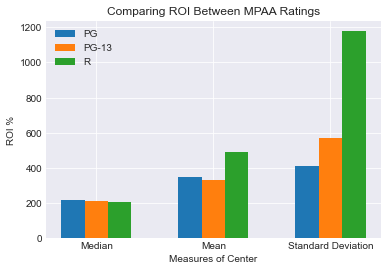

In [157]:
#aggregate graph
# create data
x = np.arange(3)
y1 = list(pg['roi'].agg(['median','mean', 'std']))
y2 = list(pg_13['roi'].agg(['median','mean','std']))
y3 = list(r['roi'].agg(['median','mean','std']))
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width)
plt.bar(x, y2, width)
plt.bar(x+0.2, y3, width)
plt.title('Comparing ROI Between MPAA Ratings')
plt.xticks(x, ['Median', 'Mean', 'Standard Deviation'])
plt.xlabel("Measures of Center")
plt.ylabel("ROI %")
plt.legend(["PG", "PG-13", "R"])
plt.style.use('seaborn-darkgrid')
plt.show()

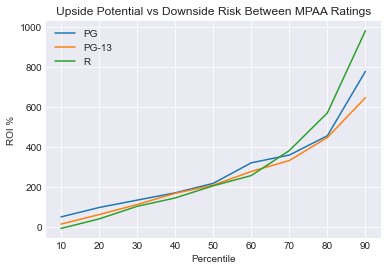

In [158]:
#comparing downside risk
# create data
x = np.arange(9)
percentile = list(range(10, 100, 10))
y1 = [np.percentile(pg['roi'], x) for x in percentile]
y2 = [np.percentile(pg_13['roi'], x) for x in percentile]
y3 = [np.percentile(r['roi'], x) for x in percentile]
  
# plot data in grouped manner of bar type
plt.plot(x, y1, label = 'PG')
plt.plot(x, y2, label = 'PG-13')
plt.plot(x, y3, label = 'R')
plt.title('Upside Potential vs Downside Risk Between MPAA Ratings')
plt.xlabel("Percentile")
plt.ylabel("ROI %")
plt.xticks(x, ['10', '20', '30', '40', '50', '60', '70', '80', '90'])
plt.legend()
plt.style.use('seaborn-darkgrid')
plt.show()

<H2>User Rating as a Metric to Explore Genre and Director </H2>

*Bring in the file names for easy access.*

In [159]:
zippedData = ['bom.movie_gross.csv.gz','imdb.name.basics.csv.gz','imdb.title.akas.csv.gz',
              'imdb.title.basics.csv.gz','imdb.title.crew.csv.gz',
              'imdb.title.principals.csv.gz','imdb.title.ratings.csv.gz',
              'rt.movie_info.tsv.gz','rt.reviews.tsv.gz','tmdb.movies.csv.gz',
              'tn.movie_budgets.csv.gz']

In [160]:
bom_movie_gross = pd.read_csv("zippedData/{}".format(zippedData[0]))
imdb_name = pd.read_csv("zippedData/{}".format(zippedData[1]))
imdb_title_aka = pd.read_csv("zippedData/{}".format(zippedData[2]))
imdb_title_basics = pd.read_csv("zippedData/{}".format(zippedData[3]))
imdb_title_crew = pd.read_csv("zippedData/{}".format(zippedData[4]))
imdb_title_principals = pd.read_csv("zippedData/{}".format(zippedData[5]))
imdb_title_rating = pd.read_csv("zippedData/{}".format(zippedData[6]))
rt_movie_info = pd.read_csv("zippedData/{}".format(zippedData[7]),sep='\t')
df8 = pd.read_csv("zippedData/{}".format(zippedData[8]),sep='\t',encoding='latin1')
tmdb_movies = pd.read_csv("zippedData/{}".format(zippedData[9]))
tn_movie_budget = pd.read_csv("zippedData/{}".format(zippedData[10]))

In this section we combined a few IMDB mini dataframes to make one joint one. Using this dataframe, we were able to explore which genres held the highest ratings in the last 20 years, and which directors have high ratings. <br><br>
First, we merged the data sets.

In [161]:
imdb=imdb_title_rating.merge(imdb_title_principals,on='tconst')
imdb=imdb.merge(imdb_title_basics,on='tconst')
imdb=imdb.merge(imdb_name,on='nconst')
imdb=imdb.merge(imdb_title_crew,on='tconst')
imdb.head()

,tconst,averagerating,numvotes,ordering,nconst,category,job,characters,primary_title,original_title,start_year,runtime_minutes,genres,primary_name,birth_year,death_year,primary_profession,known_for_titles,directors,writers
0,tt10356526,8.3,31,10,nm8994524,production_designer,NaN,NaN,Laiye Je Yaarian,Laiye Je Yaarian,2019,117.0,Romance,Kazi Rafik Ali,NaN,NaN,"production_designer,art_department","tt9190740,tt2837596,tt4773212,tt8749962",nm8353804,"nm3057599,nm4179342"
1,tt10356526,8.3,31,1,nm4718369,actor,NaN,"[""Sukh""]",Laiye Je Yaarian,Laiye Je Yaarian,2019,117.0,Romance,Harish Verma,NaN,NaN,actor,"tt3265542,tt7246718,tt8108168,tt3331954",nm8353804,"nm3057599,nm4179342"
2,tt10356526,8.3,31,2,nm10007357,actress,NaN,"[""Raunak""]",Laiye Je Yaarian,Laiye Je Yaarian,2019,117.0,Romance,Roopi Gill,NaN,NaN,actress,"tt8749962,tt9260244,tt8785138",nm8353804,"nm3057599,nm4179342"
3,tt10356526,8.3,31,3,nm8743259,actress,NaN,"[""Jaanpreet""]",Laiye Je Yaarian,Laiye Je Yaarian,2019,117.0,Romance,Rubina Bajwa,NaN,NaN,actress,"tt8125398,tt7897324,tt10081104,tt6476532",nm8353804,"nm3057599,nm4179342"
4,tt10356526,8.3,31,4,nm3760302,actor,NaN,"[""Garry Randhawa""]",Laiye Je Yaarian,Laiye Je Yaarian,2019,117.0,Romance,Amrinder Gill,NaN,NaN,"actor,music_department,soundtrack","tt4846952,tt5569468,tt6882872,tt8749962",nm8353804,"nm3057599,nm4179342"


Next, we pulled the relevant columns, dropped duplicates and dropped mising values.

In [162]:
imdb=imdb[['original_title','genres','start_year','averagerating','category','primary_profession','primary_name']].where(imdb['start_year']>2000)



For the first question, which genres have the highest rating, we pulled the two columns that we needed: average rating and genres. 

In [163]:
imdb_genre_rating=imdb[['genres','averagerating','primary_profession','primary_name']]
imdb_genre_rating.head()

,genres,averagerating,primary_profession,primary_name
0,Romance,8.3,"production_designer,art_department",Kazi Rafik Ali
1,Romance,8.3,actor,Harish Verma
2,Romance,8.3,actress,Roopi Gill
3,Romance,8.3,actress,Rubina Bajwa
4,Romance,8.3,"actor,music_department,soundtrack",Amrinder Gill


Since some of the data in the genre column contained more than one genre, we had to split the column into three seperate columns and then return them into one column.

In [164]:
imdb_genre_rating[["One","Two","Three"]]=imdb_genre_rating.genres.str.split(pat=',', n=- 1, expand=True)
imdb_genre_rating_one=imdb_genre_rating[['One','averagerating']]
imdb_genre_rating_two=imdb_genre_rating[['Two','averagerating']]    
imdb_genre_rating_three=imdb_genre_rating[['Three','averagerating']]
imdb_genre_rating_one=imdb_genre_rating_one.rename(columns={"One":"Genre"})
imdb_genre_rating_two=imdb_genre_rating_two.rename(columns={"Two":"Genre"})
imdb_genre_rating_three=imdb_genre_rating_three.rename(columns={"Three":"Genre"})
genre_rating=pd.concat([imdb_genre_rating_three,imdb_genre_rating_two,imdb_genre_rating_one])
genre_rating=genre_rating[['Genre','averagerating']]
genre_rating.isnull().sum()
genre_rating['Genre'].dropna(inplace=True)



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


We dropped the genre catergories that weren't technically movies, and the ones that have a very low average rating. 

In [165]:
genre_rating=genre_rating[genre_rating.Genre != 'Music']
genre_rating=genre_rating[genre_rating.Genre != 'Reality-TV']
genre_rating=genre_rating[genre_rating.Genre != 'News']
genre_rating=genre_rating[genre_rating.Genre != 'Game-Show']
genre_rating=genre_rating[genre_rating.Genre != 'Short']
genre_rating=genre_rating[genre_rating.Genre != 'Horror']
genre_rating=genre_rating[genre_rating.Genre != 'Western']
genre_rating=genre_rating[genre_rating.Genre != 'Thriller']
genre_rating=genre_rating[genre_rating.Genre != 'Sci-Fi']
genre_rating=genre_rating[genre_rating.Genre != 'Adult']
genre_rating

,Genre,averagerating
0,None,8.3
1,None,8.3
2,None,8.3
3,None,8.3
4,None,8.3
...,...,...
629585,Documentary,8.6
629594,Documentary,4.3
629595,Documentary,4.3
629596,Documentary,4.3


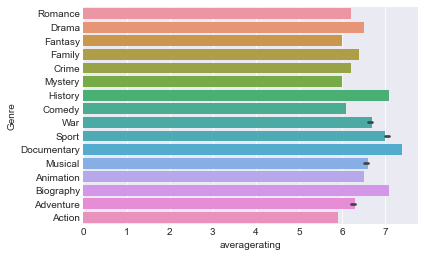

In [166]:
from numpy import median
ax3 = sns.barplot(x="averagerating", y="Genre", data=genre_rating, estimator=median)

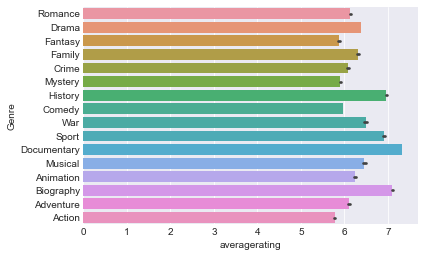

In [167]:
from numpy import mean
ax3 = sns.barplot(x="averagerating", y="Genre", data=genre_rating, estimator=mean)

Next we looked at the overall distribution of the user ratings among the different genres 

Text(0.5, 1.0, 'Distribution of User Rating in Each Genre ')

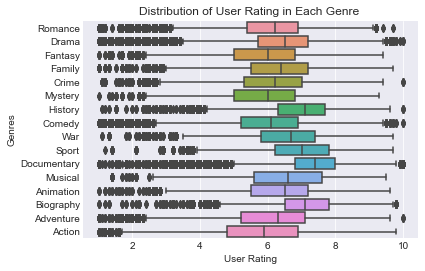

In [168]:
ax= sns.boxplot(x="averagerating",y="Genre",data=genre_rating)
ax.set_xlabel("User Rating")
ax.set_ylabel("Genres")
ax.set_title("Distribution of User Rating in Each Genre ")

In this section we looked at which directors had the highest ratings. 

In [169]:
imdb_job=imdb[['primary_profession','primary_name','averagerating']]
imdb_job[['Director','Director2','Director3']]=imdb_job.primary_profession.str.split(pat=',', n=- 1, expand=True)
imdb_job_director=imdb_job[imdb_job['primary_profession'].str.contains('director')]
imdb_job_director_name=imdb_job_director[['averagerating','primary_name']]
imdb_job_director_name=imdb_job_director_name.groupby(['primary_name']).mean().sort_values('averagerating',ascending=False)
imdb_job_director_name.head(10)



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


ValueError: Cannot mask with non-boolean array containing NA / NaN values

![jakob-owens-sOWoC7fA5DA-unsplash.jpg](images/jakob-owens-sOWoC7fA5DA-unsplash.jpg)

<H1> Release Date and ROI</H1>

*Import the data. Some of this data was gleaned from the TMDB api, cleaned and formatted, and saved as a csv using a different notebook.*

In [21]:
#dataset provided
df_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
#dataset from TMDB api
df_financial = pd.read_csv('zippedData/tmdb_financials.csv')
#reset indices to prepare for join
df_movies = df_movies.set_index('id')
df_financial = df_financial.set_index('id')
#join datasets on film ID
df = df_movies.join(df_financial,how='inner')
df.drop(['vote_average', 'vote_count','original_language', 'original_title',
       'popularity','Unnamed: 0'],axis=1,inplace = True)
df.shape

(1236, 7)

*Convert strings to appropriate datatypes and adding some columns to filter by.*

In [22]:
#formatting date/time objects and adding day, month and year columns
df['release_date']=pd.to_datetime(df['release_date'],infer_datetime_format=True)
df['release_day'] = df['release_date'].dt.day_name()
df['release_month'] = df['release_date'].dt.month_name()
df['release_year'] = df['release_date'].dt.year

#limiting the dataset to include only high budget films
df= df[df['budget'] >= 100000000]

<H4> Exploring the effect of release timing on ROI.</H4>
<br>
*Create data frames for individual months*

In [24]:
#create list of months from data set
months = list(set(df['release_month'].unique()))
#sort months as they occur through the year
months = sorted(months, key=lambda m: datetime.strptime(m, "%B"))
month_dfs = []
for month in months:
    month_dfs.append(pd.DataFrame(df[df['release_month']==month]))
months

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

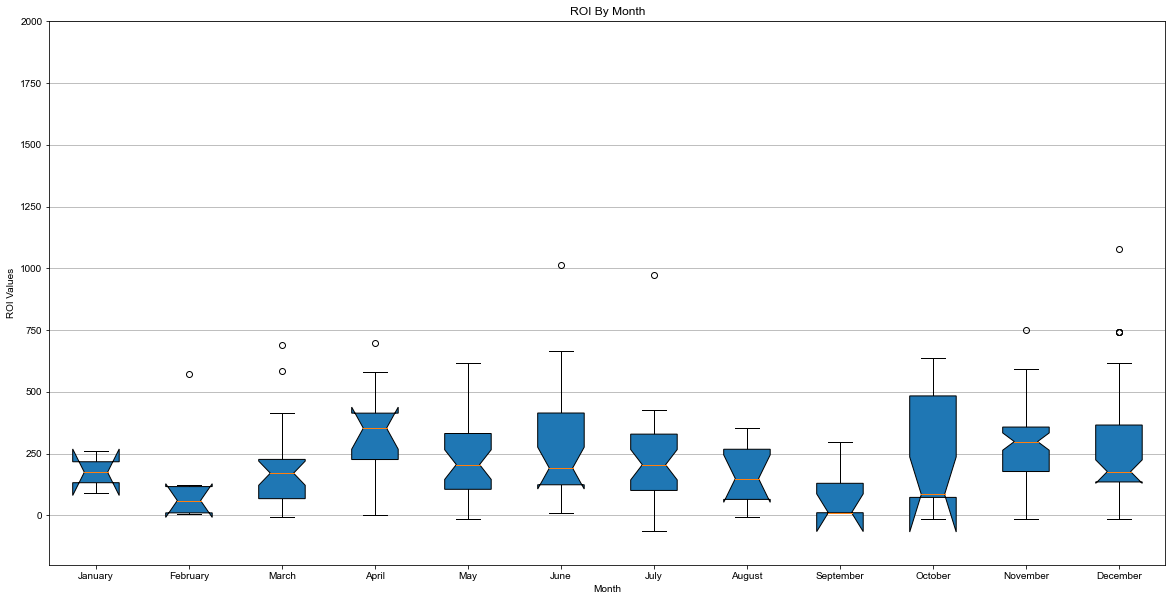

In [25]:
#for each month, create a dataframe
labels = months
all_data = []
for month in month_dfs:
    all_data.append(month['roi'])
    
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
# rectangular box plot
bplot1 = ax1.boxplot(all_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,
                     notch=True,# fill with color
                     labels=labels)  # will be used to label x-ticks
# prettify and label
ax1.set_title('ROI By Month')
ax1.yaxis.grid(True)
ax1.set_xlabel('Month')
ax1.set_ylabel('ROI Values')
ax1.set_ylim(-200,2000)

plt.style.use('seaborn-darkgrid')

plt.show()

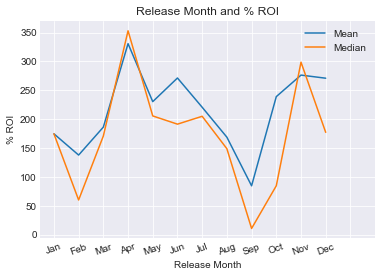

In [27]:
month_mean = []
for df in month_dfs:
    month_mean.append(df['roi'].mean())
    
month_med = []
for df in month_dfs:
    month_med.append(df['roi'].median())
    
plt.plot(month_mean, label='Mean')
plt.plot(month_med, label='Median')
plt.xticks(range(0,14),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','',''],rotation=20)
plt.style.use('seaborn-darkgrid')
plt.xlabel('Release Month')
plt.ylabel('% ROI')
plt.title('Release Month and % ROI')
plt.savefig('./images/month_and_roi.png')
plt.legend();
#this vis shows that the highest ROI, which is a %, is in April. That does NOT mean the most revenue was generated in April.
#put next to a vis showing revenue by month

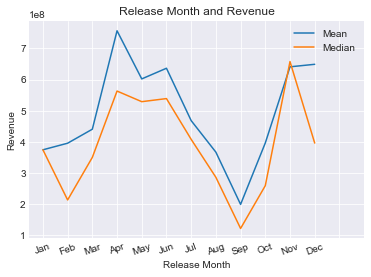

In [28]:
monthrev_mean = []
for df in month_dfs:
    monthrev_mean.append(df['revenue'].mean())
    
monthrev_med = []
for df in month_dfs:
    monthrev_med.append(df['revenue'].median())
    
plt.plot(monthrev_mean, label='Mean')
plt.plot(monthrev_med, label='Median')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','',''],rotation=20)
plt.style.use('seaborn-darkgrid')
plt.xlabel('Release Month')
plt.ylabel('Revenue')
plt.title('Release Month and Revenue')
plt.savefig('./images/month_and_rev.png')
plt.legend();

## Insights: Release Month ##
By viewing the monthly median and mean on the same plot with the Y axis as the ROI % and the X axis as months, we can see the spikes in ROI by month. We can also begin to understand, at a high level, the consistency or variability by month. The spikes in ROI occur un March and October.

*Create data frames for individual days.*

In [29]:
days = list(df['release_day'].unique())
df_mon= df[df['release_day'] == 'Monday']
df_tues= df[df['release_day'] == 'Tuesday']
df_wed= df[df['release_day'] == 'Wednesday']
df_thurs= df[df['release_day'] == 'Thursday']
df_fri= df[df['release_day'] == 'Friday']
df_sat= df[df['release_day'] == 'Saturday']
df_sun= df[df['release_day'] == 'Sunday']

day_dfs = [df_mon,df_tues,df_wed,df_thurs,df_fri,df_sat,df_sun]

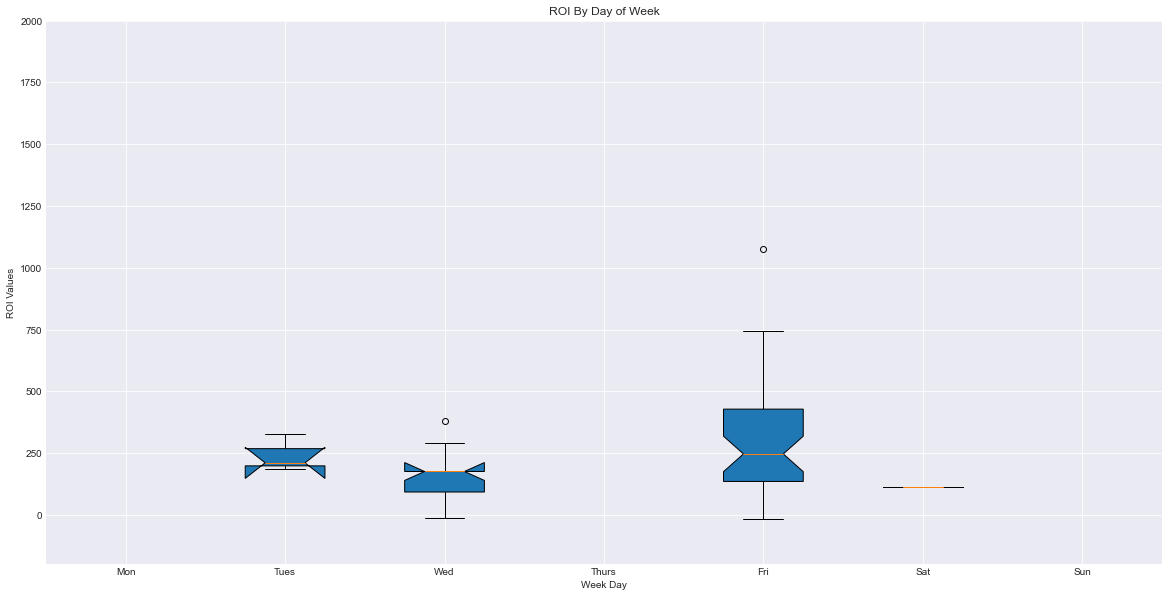

In [30]:
labels = ['Mon', 'Tues', 'Wed','Thurs','Fri','Sat','Sun']
all_data = [df_mon['roi'],df_tues['roi'],df_wed['roi'],df_thurs['roi'],df_fri['roi'],df_sat['roi'],df_sun['roi']]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
# rectangular box plot
bplot1 = ax1.boxplot(all_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,
                     notch=True,# fill with color
                     labels=labels)  # will be used to label x-ticks

# prettify and label
ax1.set_title('ROI By Day of Week')
ax1.yaxis.grid(True)
ax1.set_xlabel('Week Day')
ax1.set_ylabel('ROI Values')
ax1.set_ylim(-200,2000)
plt.style.use('seaborn-darkgrid')
plt.savefig('./images/day_of_week.png')
plt.show()

## Insights: Release Day ##
The majority of films are released on Friday, and films released on Friday have the highest ROI.<hr>

<H1> Runtime and ROI </H1>

First, let's see how the runtimes are distributed for films in the last 20 years.

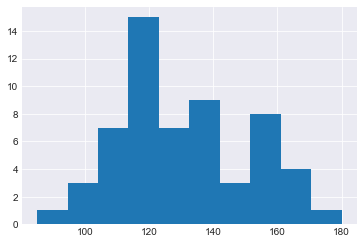

In [33]:
df['runtime'].hist()
plt.style.use('seaborn-darkgrid');

It looks like the bulk of films are between 105-140 minutes long.<br>
Seeing that, I'm curious to know if our attention span and resulting appetite for films has changed in the last 20 years. I'll further filter the data set to see runtimes in the last 10 and last 5 years only.

''

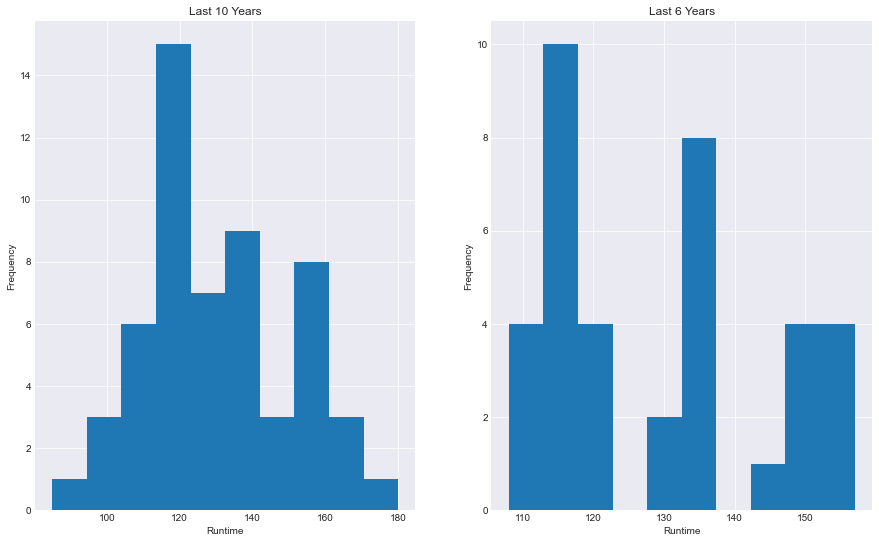

In [35]:
df_last10 = df[df['release_year']>2009]
df_last6 = df[df['release_year']>2014]
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(15,9))
ax1.hist(df_last10['runtime'])
ax1.set_title('Last 10 Years')
ax1.set_xlabel('Runtime')
ax1.set_ylabel('Frequency')
ax2.hist(df_last6['runtime'])
ax2.set_title('Last 6 Years')
ax2.set_xlabel('Runtime')
ax2.set_ylabel('Frequency')
plt.savefig('./images/runtime.png')
;

There doesn't appear to be much change in the distribution of runtime across the subsets of data. <br> Initial observations are that the median length film amongst high ROI films is between 110-120 minutes in length.<br> Now I will calculate the correlation between runtime and roi using films that are within the 90-130 minute range.

In [36]:
df_med_length = df[(df['runtime']> 80) & (df['runtime']< 130)]
df['runtime'].corr(df['roi'])

0.5199317535663471

Within a range of 80 and 130 minutes of runtime, the runtime and ROI are positively correlated. Films outside of that range perform poorly. 

In [38]:
d = np.polyfit(df['runtime'],df['roi'],1)
f = np.poly1d(d)
# df.insert(6,'run_reg',f(df['runtime']))

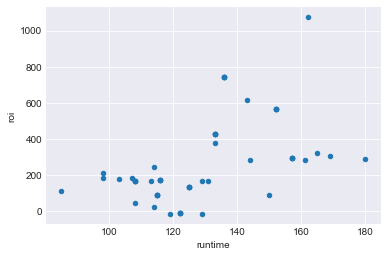

In [39]:
ax=df.plot.scatter(x='runtime', y='roi')
# df_median.plot(x='runtime',y='run_reg',color='red',legend=True,ax=ax);

In [40]:
df_shorter = df[df['runtime']<110]
len(df_shorter)

10

In [41]:
df_shorter['runtime'].corr(df_shorter['roi'])

0.048113289545011796

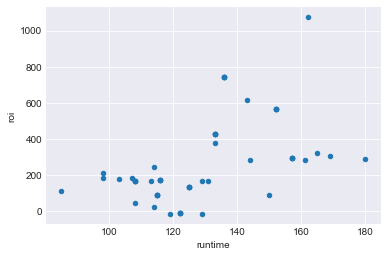

In [42]:
d = np.polyfit(df_shorter['runtime'],df_shorter['roi'],1)
f = np.poly1d(d)
# df.insert(6,'run_reg',f(df['runtime']))

ax=df.plot.scatter(x='runtime', y='roi')
# df.plot(title='Runtime and %ROI',x='runtime',y='run_reg',color='blue',legend=False,ax=ax);

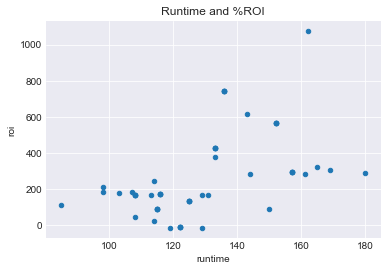

In [43]:
d = np.polyfit(df['runtime'],df['roi'],1)
f = np.poly1d(d)
# df.insert(6,'run_reg',f(df['runtime']))

ax=df.plot.scatter(title='Runtime and %ROI',x='runtime', y='roi')
# df.plot(title='Runtime and %ROI',x='runtime',y='run_reg',color='blue',legend=False,ax=ax)
ax.savefig='./images/runtime_ROI.png';